# Import Libraires 

In [57]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import pickle
import matplotlib.pyplot as plt

# Load Data

In [58]:
with open("data.pkl", "rb") as f:
    l = pickle.load(f)
l

array([[[0.02498245, 0.02570206, 0.02440295, ..., 0.01198664,
         0.01114914, 0.01478702],
        [0.01955402, 0.02351876, 0.02218845, ..., 0.01402334,
         0.01109786, 0.00994285],
        [0.01894124, 0.0218457 , 0.02272888, ..., 0.01710318,
         0.01204097, 0.01065969],
        ...,
        [0.01972517, 0.01671813, 0.01694844, ..., 0.01257978,
         0.0120191 , 0.01530671],
        [0.01967395, 0.0172272 , 0.01683865, ..., 0.01267058,
         0.01023725, 0.0114565 ],
        [0.01509957, 0.01441063, 0.015171  , ..., 0.01146287,
         0.01060696, 0.01274146]],

       [[0.01990312, 0.02342614, 0.02112563, ..., 0.00473524,
         0.00557833, 0.00611488],
        [0.01545785, 0.0162411 , 0.01703112, ..., 0.00446532,
         0.00597168, 0.00599413],
        [0.0151665 , 0.0140051 , 0.01331244, ..., 0.00430727,
         0.00529792, 0.00563137],
        ...,
        [0.01622873, 0.01906821, 0.02347827, ..., 0.0087043 ,
         0.00807017, 0.01003715],
        [0.0

In [59]:
l = np.array(l)

In [60]:
    np.random.shuffle(l)

In [61]:
def mean_conv(img):
    size = 6
    stride = 5
    ret = np.ones((3,3))
    stx=0
    for i in range(3):
        sty = 0
        for j in range(3):
            ret[i][j] = np.mean(img[stx:stx+size, sty:sty+size])
            sty += stride
        stx += stride
    
    return ret

In [76]:
#SIZE = 16
#high_img = []
#for i in tqdm(range(len(l))):
#    img = l[i]
#    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])    
#   #resizing image
#    img = cv2.resize(img, (SIZE, SIZE))
#    high_img.append(img)
#temp_img = []
#low_img = []
#for i in tqdm(range(len(l))):
#    img = l[i]
#    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])    
#    #resizing image
#    img = cv2.resize(img, (SIZE, SIZE))
#    temp = mean_conv(img)
#    temp_img.append(temp)
#    img = cv2.resize(temp, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
#    low_img.append(img)


#adjust to 16 by 16
SIZE = 16
high_img = []
for i in tqdm(range(len(l))):
    img = l[i]
    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])
    if (i!=0 and np.array_equal(img, previmg)):
        continue
    previmg = img
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    high_img.append(img)

#remove all duplicates
high_img = np.unique(np.array(high_img), axis=0)
high_img.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:00<00:00, 26694.11it/s]


(1984, 16, 16)

# Data Visualization

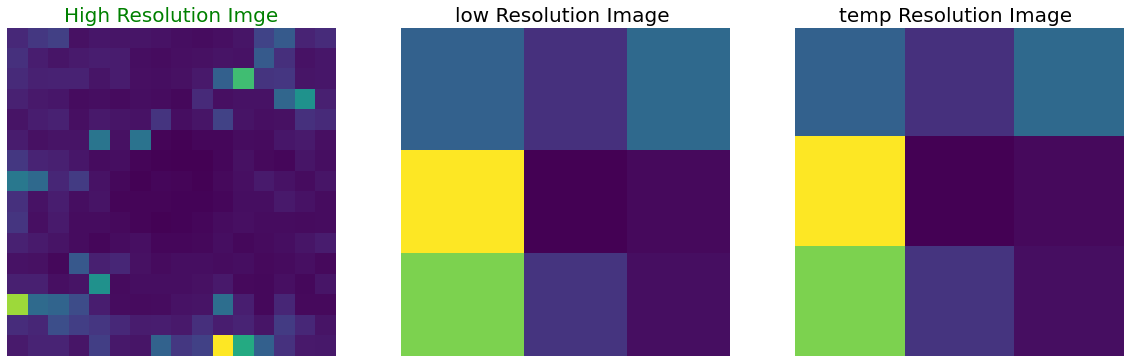

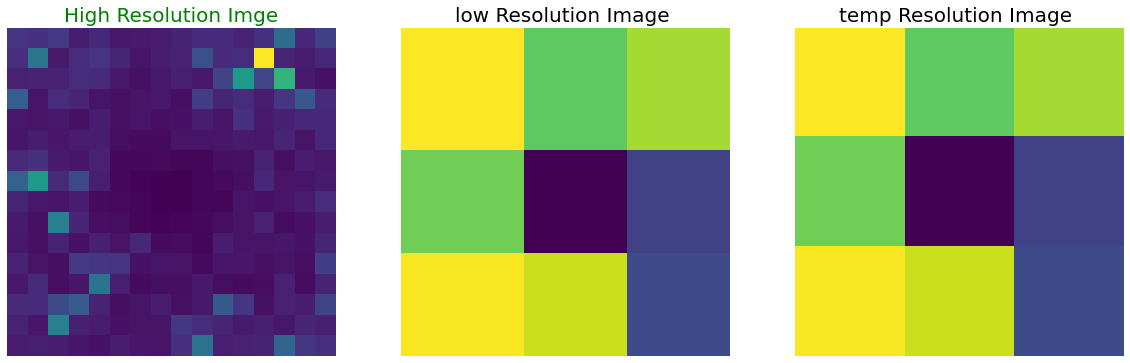

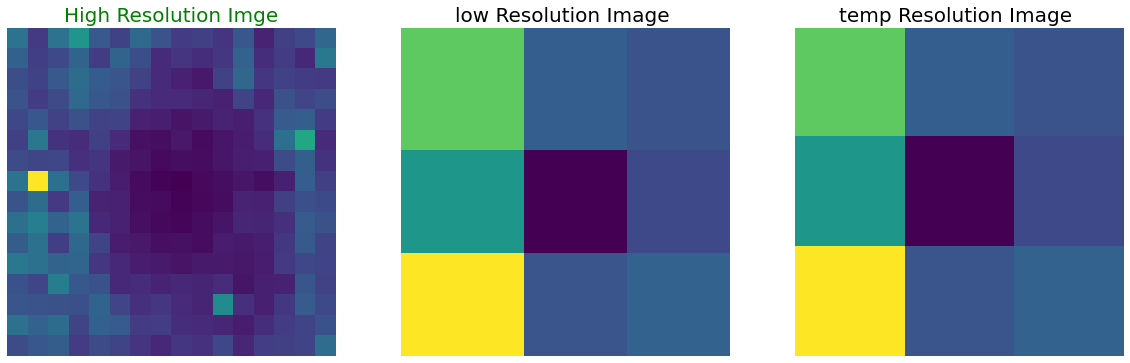

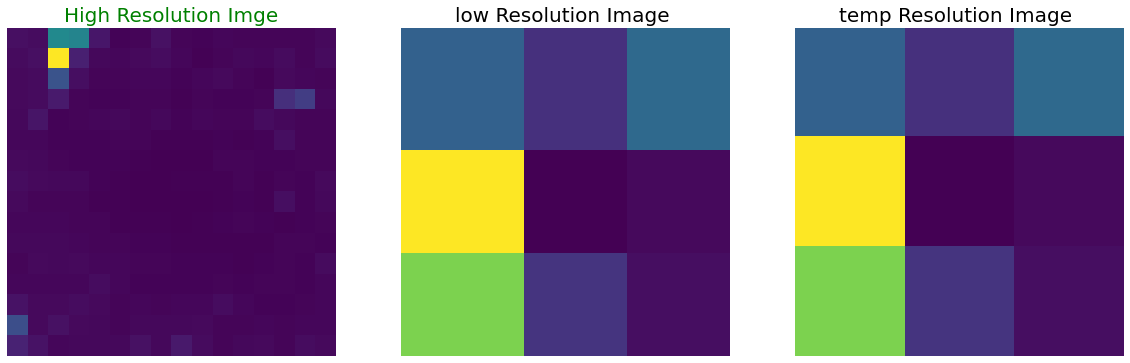

In [77]:
for i in range(4):
    a = np.random.randint(0,2000)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('temp Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(temp_img[a])
    plt.axis('off')

# Slicing and Reshaping Images

In [64]:
#this is correct. needs to be substituted in.
#temp_img = []
#low_img = []
#for i in tqdm(range(len(high_img))):
#    img = high_img[i]
#   #resizing image
#    img = cv2.resize(img, (SIZE, SIZE))
#    temp = mean_conv(img)
#    temp_img.append(temp)
#    img = cv2.resize(temp, (SIZE, SIZE), interpolation=cv2.INTER_CUBIC)
#    low_img.append(img)

In [78]:
#bicubic interpolation
def mean_conv_variable(img, outputDimm):
    size = round(SIZE/outputDimm)
    stride = size-1
    ret = np.ones((outputDimm,outputDimm))
    stx=0
    for i in range(outputDimm):
        sty = 0
        for j in range(outputDimm):
            ret[i][j] = np.mean(img[stx:stx+size, sty:sty+size])
            sty += stride
        stx += stride
    
    return ret

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1984/1984 [00:01<00:00, 1470.49it/s]


(-0.5, 15.5, 15.5, -0.5)

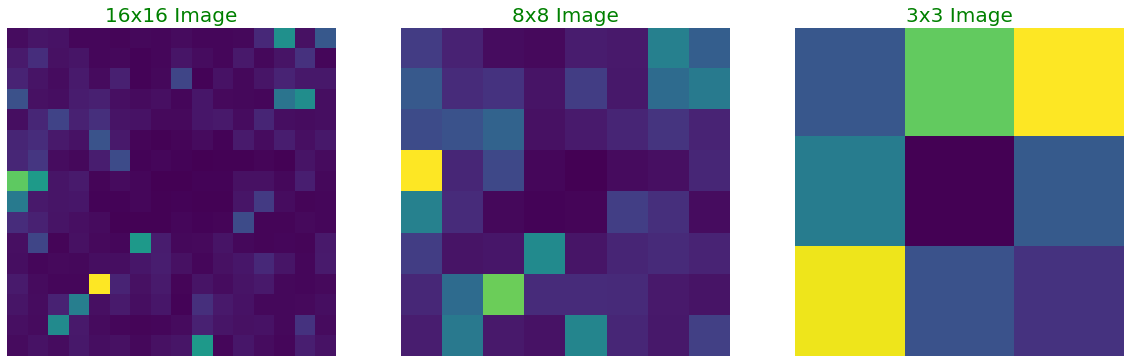

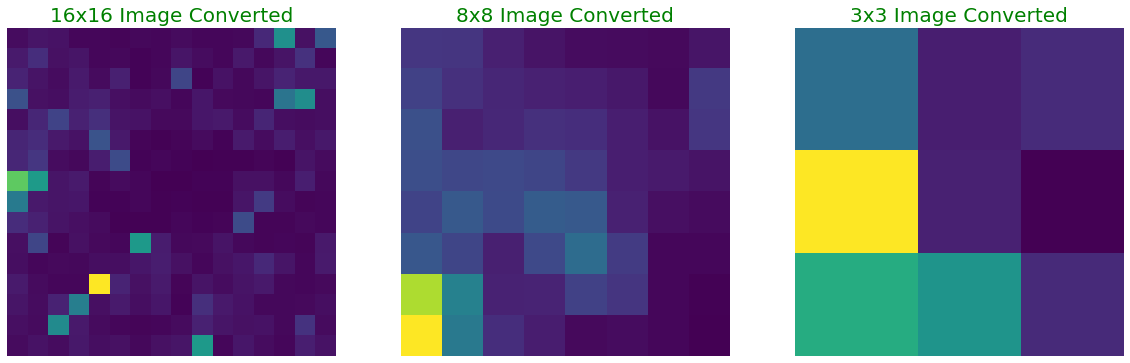

In [91]:
#stacked srcnn idea
#iterate over all data and upscale it from 16x16 to different resolutions (3x3, 8x8, 16x16)
from PIL import Image

#train_high_image contains 16x16 images
#train_low_image contains 3x3 images

def convertImages(train, outputDimm):
    temp_train = []
    for i in tqdm(range(len(train))):
        img = train[i]
        img[np.isnan(img)]=np.mean(img[~np.isnan(img)])    
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        temp = mean_conv_variable(img, outputDimm)
        temp_img.append(temp)
        img = cv2.resize(temp, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
        temp_train.append(img) 
    return temp_train

#3x3 images
train_3x3 = []
for img in train_high_image:
    scaled_image = cv2.resize(img, (3, 3))  # when scaling we scale original image to 24x24 
    train_3x3.append(scaled_image)
#train_3x3_converted = convertImages(train_3x3, 3)
train_3x3_converted = convertImages(train_high_image, 3)

#8x8 images
train_8x8 = []
for img in train_high_image:
    scaled_image = cv2.resize(img, (8, 8))  # when scaling we scale original image to 24x24 
    train_8x8.append(scaled_image)
#train_8x8_converted = convertImages(train_8x8, 8)
train_8x8_converted = convertImages(train_high_image, 8)


#16x16
train_16x16 = train_high_image
   
#display unconverted scaled images
a = np.random.randint(0,1000)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('16x16 Image', color = 'green', fontsize = 20)
plt.imshow(train_16x16[a])
plt.axis('off')
plt.subplot(1,3,2)
plt.title('8x8 Image', color = 'green', fontsize = 20)
plt.imshow(train_8x8[a])
plt.axis('off')
plt.subplot(1,3,3)
plt.title('3x3 Image', color = 'green', fontsize = 20)
plt.imshow(train_3x3[a])
plt.axis('off')

#display converted images
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('16x16 Image Converted', color = 'green', fontsize = 20)
plt.imshow(train_16x16[a])
plt.axis('off')
plt.subplot(1,3,2)
plt.title('8x8 Image Converted', color = 'green', fontsize = 20)
plt.imshow(train_8x8_converted[a])
plt.axis('off')
plt.subplot(1,3,3)
plt.title('3x3 Image Converted', color = 'green', fontsize = 20)
plt.imshow(train_3x3_converted[a])
plt.axis('off')

In [102]:
#16x16 -> train_high_image
train_high_image = train_16x16[:1900]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,1))
validation_high_image = high_img[1900:1984]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,1))
test_high_image = high_img[1900:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,1))

#3x3 -> train_low_image
train_low_image = train_low_image[:1900]
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,1))
validation_low_image = low_img[1900:1984]
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,1))
test_low_image = low_img[1984:]
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,1))

#3x3 + 16x16 -> shape
print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

#8x8 -> train_high_image_8x8
train_high_image_8x8 = train_8x8_converted[:1900]
train_high_image_8x8 = np.reshape(train_high_image_8x8,(len(train_high_image_8x8),SIZE,SIZE,1))
validation_high_image_8x8 = train_8x8_converted[1900:1984]
validation_high_image_8x8 = np.reshape(validation_high_image_8x8,(len(validation_high_image_8x8),SIZE,SIZE,1))

#8x8 -> shape
print("Shape of training images:", train_high_image_8x8.shape)
print("Shape of validation images:", validation_high_image_8x8.shape)

Shape of training images: (1900, 16, 16, 1)
Shape of test images: (84, 16, 16, 1)
Shape of validation images: (84, 16, 16, 1)
Shape of training images: (1900, 16, 16, 1)
Shape of validation images: (84, 16, 16, 1)


# Defining Model

In [107]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape = [SIZE,SIZE,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    #upsampling
    u2 = up(256,(3,3),False)(d4)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(1,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)


model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 sequential_24 (Sequential)     (None, 8, 8, 128)    1280        ['input_4[0][0]']                
                                                                                                  
 sequential_25 (Sequential)     (None, 4, 4, 128)    147584      ['sequential_24[0][0]']          
                                                                                                  
 sequential_26 (Sequential)     (None, 2, 2, 256)    296192      ['sequential_25[0][0]']          
                                                                                            

# Compile 

In [109]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Fitting model

In [ ]:
#3x3 -> 8x8 model
model.fit(train_low_image, train_high_image_8x8, epochs = 40, batch_size = 16,
          validation_data = (train_low_image, train_high_image_8x8))

#8x8 -> 16x16 model
#model.fit(train_high_image_8x8, train_high_image, epochs = 40, batch_size = 16,
#          validation_data = (train_high_image_8x8, train_high_image))

Epoch 1/40
119/119 [==============================] - 17s 142ms/step - loss: 0.0530 - acc: 0.0000e+00 - val_loss: 0.0636 - val_acc: 0.0000e+00
Epoch 2/40
119/119 [==============================] - 17s 144ms/step - loss: 0.0340 - acc: 0.0000e+00 - val_loss: 0.0481 - val_acc: 0.0000e+00
Epoch 3/40
119/119 [==============================] - 17s 142ms/step - loss: 0.0298 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 4/40
 27/119 [=====>........................] - ETA: 9s - loss: 0.0141 - acc: 0.0000e+00

# Prediction Visualization

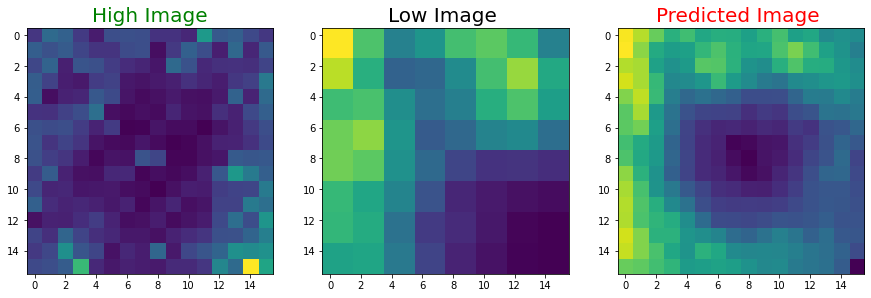

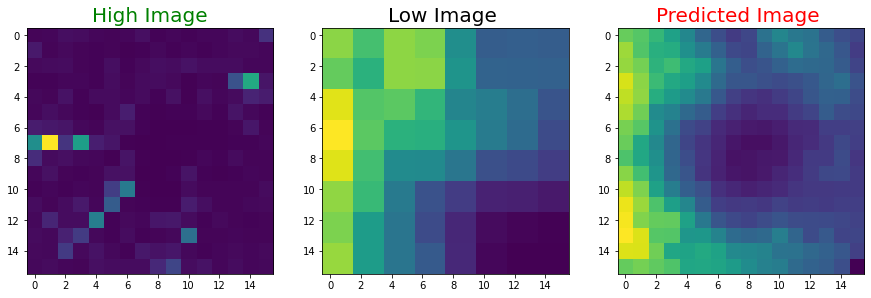

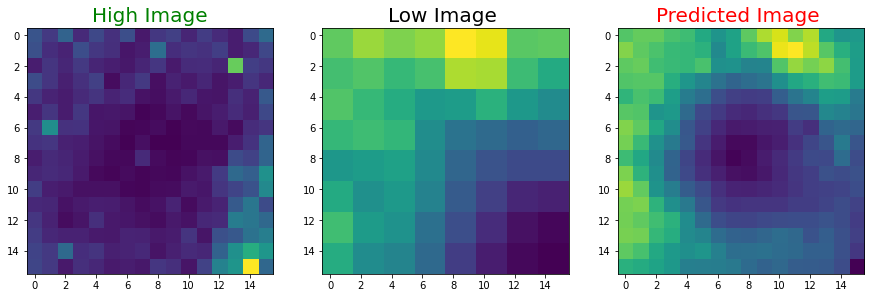

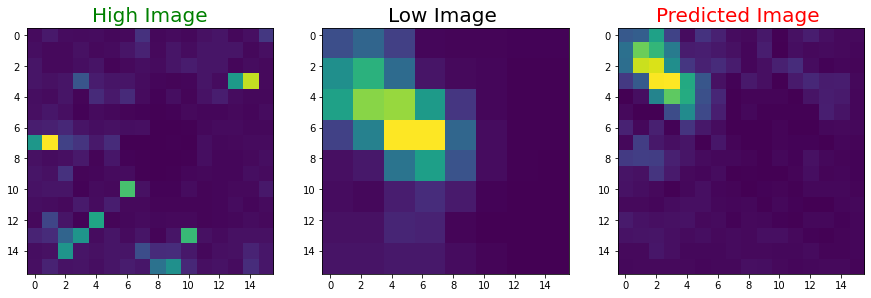

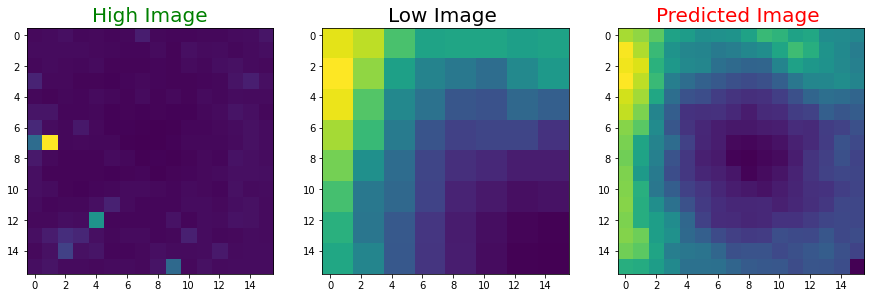

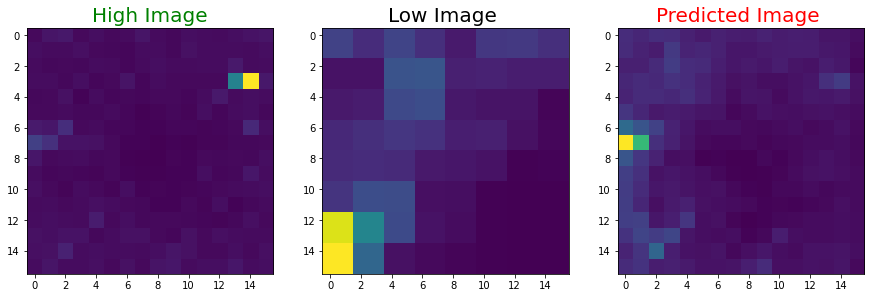

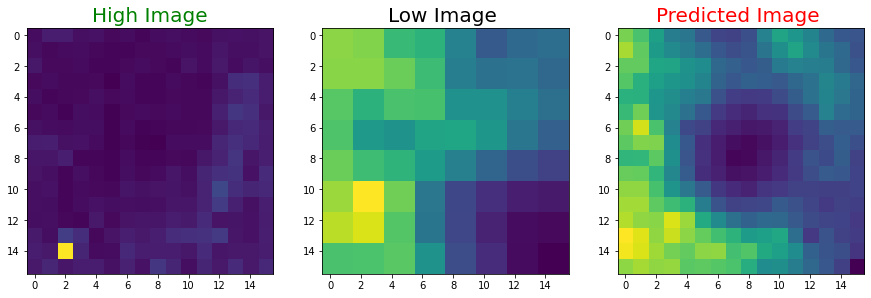

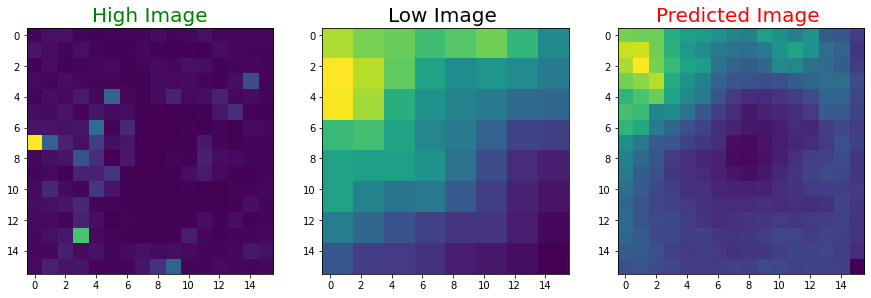

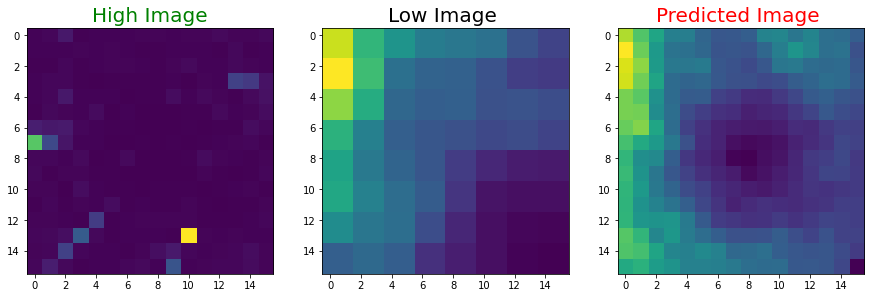

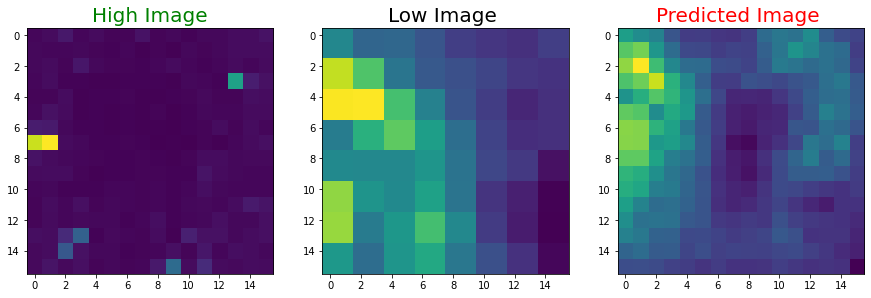

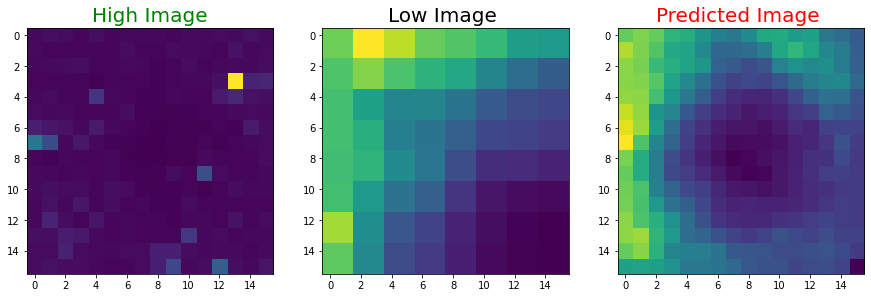

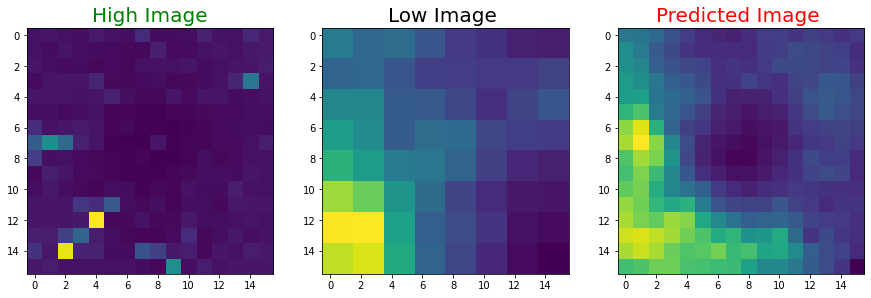

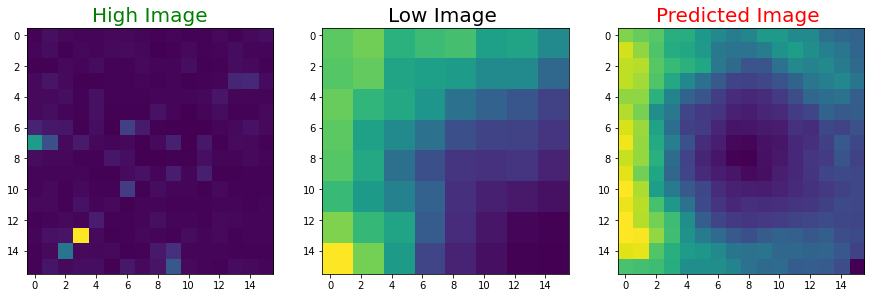

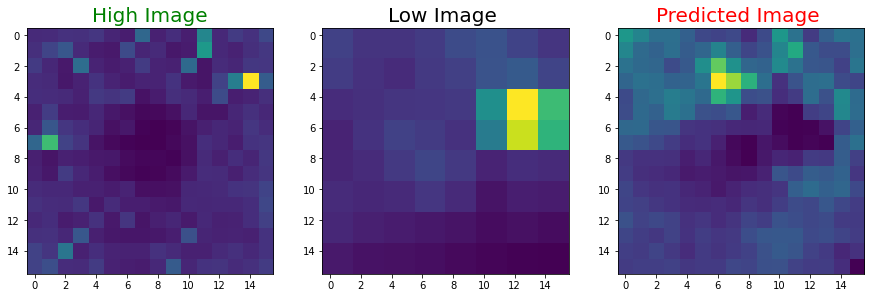

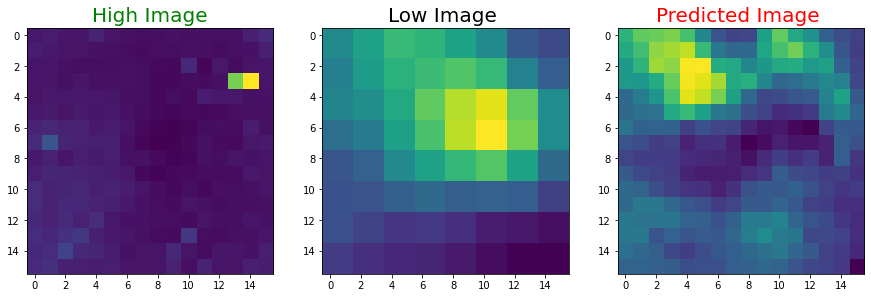

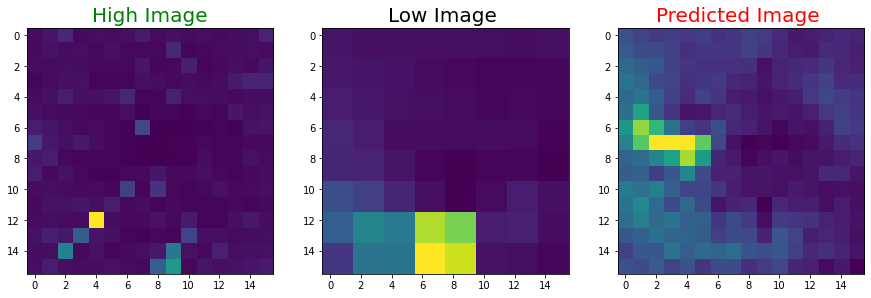

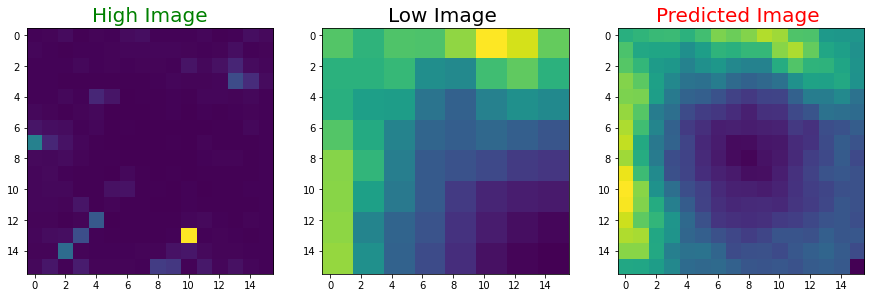

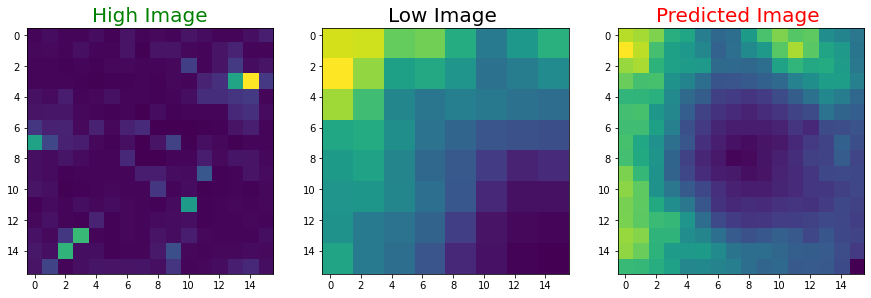

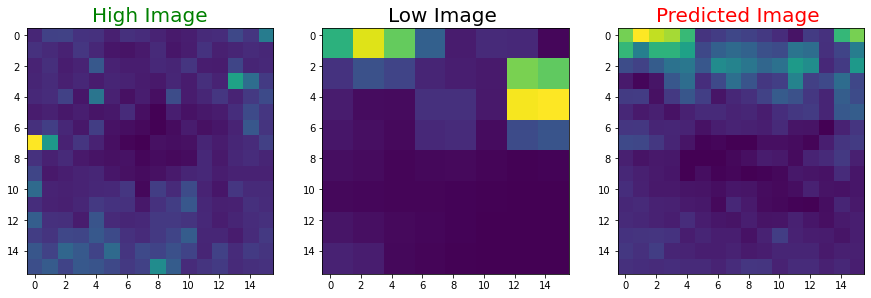

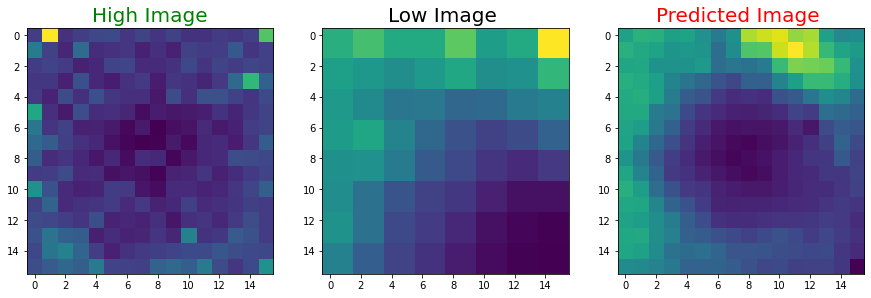

In [104]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(0,20):
    
    predicted = np.clip(model.predict(validation_high_image_8x8[i].reshape(1,SIZE, SIZE,1)),0.0,1.0).reshape(SIZE, SIZE,1)
    plot_images(train_high_image[i], validation_high_image_8x8[i],predicted)

# Saving model

In [105]:
model.save("final_model_new_8x8->16x16.h5")

## Thank You !!!